In [1]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

fatal: destination path 'clothing-dataset-small' already exists and is not an empty directory.


In [2]:
import torch

In [3]:
from PIL import Image
import numpy as np

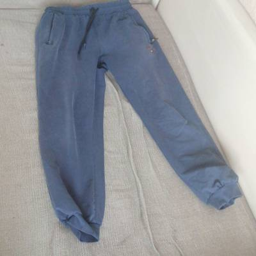

In [4]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img.resize((256, 256))

In [5]:
X = np.array(img.resize((224, 224)))

In [7]:
import torchvision.models as models
from torchvision import transforms

In [8]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval();

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/pgonzalezpr/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 40.6MB/s]


In [9]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
x = preprocess(img)

batch_t = torch.unsqueeze(x, 0)

with torch.no_grad():
    output = model(batch_t)

_, indices = torch.sort(output, descending=True)

indices

tensor([[608, 834, 474, 841, 689, 824, 501, 885, 906, 869, 601, 911, 775, 735,
         457, 655, 697, 578, 610, 434, 797, 411, 399, 452, 842, 568, 431, 617,
         516, 678, 591, 414, 796, 570, 840, 523, 793, 630, 636, 894, 903, 464,
         638, 502, 658, 614, 465, 588, 830, 515, 589, 691, 749, 808, 435, 529,
         780, 606, 806, 728, 837, 672, 887, 459, 643, 615, 702, 552, 480, 514,
         597, 777, 774, 512, 600, 823, 731, 490, 680, 790, 473, 419, 794, 715,
         772, 389, 602, 914, 451, 233, 667, 223, 652, 639, 750, 836, 831, 400,
         520, 676, 897, 876, 237, 770, 669, 585, 838, 748, 977, 177, 153, 559,
         395, 443, 487, 416, 461, 785, 982, 258, 172, 882, 257, 872, 456, 477,
         999, 801, 587, 169, 183, 171, 713, 499, 195, 741, 358, 584, 182, 463,
         250, 151, 700, 558, 170,  34, 447, 936, 557, 679, 224, 433, 543, 259,
         178, 222, 771, 879, 445, 513, 683, 627, 753, 843, 462, 765, 202, 197,
         173, 861, 265, 246, 792, 192, 811, 646, 256

In [11]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt


--2025-12-29 16:30:05--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-12-29 16:30:05 (33.3 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [13]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


In [14]:
import os
from torch.utils.data import Dataset

class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [16]:
from torch.utils.data import DataLoader

train_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
import torch.nn as nn

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [18]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device);

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [20]:
1200 / 32

37.5

In [ ]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10
  Train Loss: 1.5725, Train Acc: 0.6056
  Val Loss: 0.8412, Val Acc: 0.7214
Epoch 2/10
  Train Loss: 0.7377, Train Acc: 0.7735
  Val Loss: 0.7947, Val Acc: 0.7654
Epoch 3/10
  Train Loss: 0.7256, Train Acc: 0.7790
  Val Loss: 1.2063, Val Acc: 0.6833
Epoch 4/10
  Train Loss: 0.6826, Train Acc: 0.8129
  Val Loss: 0.8315, Val Acc: 0.7449
Epoch 5/10
  Train Loss: 0.6679, Train Acc: 0.8142
  Val Loss: 1.0058, Val Acc: 0.7595
Epoch 6/10
  Train Loss: 0.5734, Train Acc: 0.8347
  Val Loss: 1.0005, Val Acc: 0.7625
Epoch 7/10
  Train Loss: 0.5982, Train Acc: 0.8409
  Val Loss: 1.5553, Val Acc: 0.7067
Epoch 8/10
  Train Loss: 0.5967, Train Acc: 0.8435
  Val Loss: 1.0097, Val Acc: 0.7771
Epoch 9/10
  Train Loss: 0.4962, Train Acc: 0.8533
  Val Loss: 1.1970, Val Acc: 0.7449
Epoch 10/10
  Train Loss: 0.5639, Train Acc: 0.8527
  Val Loss: 1.4270, Val Acc: 0.7390


In [ ]:
def make_model(learning_rate=0.01):
    model = ClothingClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [ ]:
for lr in [0.001, 0.1]: #0.01, 0.1]:
  print("learning rate =", lr)
  model, optimizer = make_model(lr)
  train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

learning rate = 0.001
Epoch 1/10
  Train Loss: 1.2741, Train Acc: 0.5929
  Val Loss: 0.8308, Val Acc: 0.7390
Epoch 2/10
  Train Loss: 0.7535, Train Acc: 0.7660
  Val Loss: 0.6788, Val Acc: 0.7771
Epoch 3/10
  Train Loss: 0.6132, Train Acc: 0.8074
  Val Loss: 0.6109, Val Acc: 0.8035
Epoch 4/10
  Train Loss: 0.5551, Train Acc: 0.8282
  Val Loss: 0.5957, Val Acc: 0.7859
Epoch 5/10
  Train Loss: 0.5127, Train Acc: 0.8370
  Val Loss: 0.5618, Val Acc: 0.8123
Epoch 6/10
  Train Loss: 0.4795, Train Acc: 0.8383
  Val Loss: 0.5536, Val Acc: 0.8358
Epoch 7/10
  Train Loss: 0.4380, Train Acc: 0.8569
  Val Loss: 0.5468, Val Acc: 0.8240
Epoch 8/10
  Train Loss: 0.3965, Train Acc: 0.8804
  Val Loss: 0.5510, Val Acc: 0.7977
Epoch 9/10
  Train Loss: 0.4053, Train Acc: 0.8690
  Val Loss: 0.5610, Val Acc: 0.7918
Epoch 10/10
  Train Loss: 0.3678, Train Acc: 0.8869
  Val Loss: 0.5623, Val Acc: 0.8123
learning rate = 0.1
Epoch 1/10
  Train Loss: 13.5669, Train Acc: 0.5945
  Val Loss: 7.8114, Val Acc: 0.6774

KeyboardInterrupt: 

In [ ]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'clothing_v4_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [ ]:
import torch.nn as nn

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x


def make_model(
        learning_rate=0.01,
        size_inner=100,
        droprate=0.2,
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate,
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [ ]:
num_epochs = 50

model, optimizer = make_model(
    learning_rate=0.001,
    size_inner=100,
    droprate=0.2,
)

train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/50
  Train Loss: 1.5557, Train Acc: 0.4827
  Val Loss: 0.9903, Val Acc: 0.6804
Checkpoint saved: clothing_v4_01_0.680.pth
Epoch 2/50
  Train Loss: 0.9594, Train Acc: 0.6871
  Val Loss: 0.7645, Val Acc: 0.7654
Checkpoint saved: clothing_v4_02_0.765.pth
Epoch 3/50
  Train Loss: 0.7822, Train Acc: 0.7314
  Val Loss: 0.6394, Val Acc: 0.7947
Checkpoint saved: clothing_v4_03_0.795.pth
Epoch 4/50
  Train Loss: 0.6991, Train Acc: 0.7588
  Val Loss: 0.5775, Val Acc: 0.8123
Checkpoint saved: clothing_v4_04_0.812.pth
Epoch 5/50
  Train Loss: 0.6513, Train Acc: 0.7731
  Val Loss: 0.5948, Val Acc: 0.7977
Epoch 6/50
  Train Loss: 0.6163, Train Acc: 0.7950
  Val Loss: 0.5955, Val Acc: 0.7859


KeyboardInterrupt: 

In [ ]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

The output from `torchsummary` provides a detailed look at the layers in your `ClothingClassifierMobileNet` model:

*   **Layer (type)**: This column lists the type of each layer in the network (e.g., Conv2d, BatchNorm2d, ReLU6, InvertedResidual, Linear, AdaptiveAvgPool2d, Dropout).
*   **Output Shape**: This shows the shape of the tensor that is output by each layer. The first dimension `[-1]` represents the batch size, which is variable. For convolutional layers, the shape is typically `[batch_size, channels, height, width]`. For linear layers, it's `[batch_size, features]`.
*   **Param #**: This column indicates the number of parameters in each layer. These are the weights and biases that the model learns during training.
*   **Total params**: This is the total number of parameters in the entire model.
*   **Trainable params**: This shows the number of parameters that will be updated during the training process. Since we froze the base MobileNetV2 layers (`param.requires_grad = False`), these parameters are not trainable.
*   **Non-trainable params**: These are the parameters that are fixed and will not be updated during training. These are the parameters from the pre-trained MobileNetV2 base model.
*   **Input size (MB)**: The estimated size of the input data in megabytes.
*   **Forward/backward pass size (MB)**: The estimated memory required for the forward and backward passes through the network.
*   **Params size (MB)**: The estimated size of the model parameters in megabytes.
*   **Estimated Total Size (MB)**: The estimated total memory required by the model.

From this summary, we can see that:

*   The base MobileNetV2 model has a large number of parameters, but they are non-trainable as intended.
*   The trainable parameters are primarily in the new `inner` and `output_layer` that we added for our clothing classification task.
*   The output shape of the final `Linear-161` layer is `[-1, 10]`, which corresponds to the 10 classes in our clothing dataset.

In [ ]:
path = '/content/clothing_v4_04_0.812.pth'

In [ ]:
model = ClothingClassifierMobileNet(size_inner=100, droprate=0.2, num_classes=10)
model.load_state_dict(torch.load(path))
model.to(device)
model.eval();

In [ ]:
x = val_transforms(img)
batch_t = torch.unsqueeze(x, 0).to(device)

with torch.no_grad():
    output = model(batch_t)

In [ ]:
dict(zip(classes, output[0].to('cpu')))

{'dress': tensor(-0.0515),
 'hat': tensor(-3.1840),
 'longsleeve': tensor(0.4212),
 'outwear': tensor(-0.1710),
 'pants': tensor(5.4595),
 'shirt': tensor(-0.8515),
 'shoes': tensor(-0.9554),
 'shorts': tensor(0.5324),
 'skirt': tensor(0.3357),
 't-shirt': tensor(-3.1020)}

In [ ]:
classes = ['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.4 MB/s eta 0:00:00


In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "clothing_classifier_mobilenet_v2.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipython-input-3870230885.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
